In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ================================================= Flexible Layer ================================================================================

    
class FlexiLayer(nn.Module): # class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        super(FlexiLayer, self).__init__()
        
        self.t_1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, self.padding)
        self.t_2 = nn.MaxPool2d(self.kernel_size, self.stride, self.padding) # get max result with the same kernel size
        self.m = nn.Sigmoid()
        
        self.threshold1 = Variable(torch.randn((1, self.out_channels, 30, 30)))
        
        self.thresh_mean = []
        
    def forward(self, t):
        
        #self.threshold1.expand(t.size(0), self.out_channels, 30, 30)
        
        
        #cond = torch.sub(self.t_2(t), self.threshold1.cuda())
        #t_2_2 = self.m(cond*50)*self.t_2(t) # 
        #t_1_1 = self.m(cond*(-50))*self.t_1(t) # 
        #t = torch.add(t_2_2, t_1_1)
        
        return self.t_1(t)

    # ================================================= VGG-16 Network ================================================================================
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.block1 = nn.Sequential(
                      nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      FlexiLayer(in_channels = 64,out_channels = 64,kernel_size = 3, padding =0),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
                      #nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.3))

        self.block2 = nn.Sequential(
                      nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block3 = nn.Sequential(
                      nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 256,out_channels = 256,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.4))

        self.block4 = nn.Sequential(
                      nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2) ,
                      nn.Dropout2d(0.4))

        self.block5 = nn.Sequential(
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3,padding = 1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(in_channels = 512,out_channels = 512,kernel_size = 3, padding =1),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=2),
                      nn.Dropout2d(0.5) )

        self.fc =     nn.Sequential(
                      nn.Linear(512,100),
                      nn.Dropout(0.5),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(100,10), )




    def forward(self,x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)

        return out


In [2]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#from models.VGG16_with_flex_v5 import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])


trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)

#create a dataset subset
sampler_train = list(range(0, len(trainset), 50))
trainset_samp = torch.utils.data.Subset(trainset, sampler_train)

trainloader = torch.utils.data.DataLoader(trainset_samp, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
plane   car   cat   car


In [3]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

14,775,646 total parameters.
14,775,646 trainable parameters.


Epoch:  0   Loss:  24.801506996154785   Train Accuracy : 9.4


Test accuracy: 10 %
Epoch:  1   Loss:  24.36002230644226   Train Accuracy : 8.6


Test accuracy: 10 %
Epoch:  2   Loss:  23.703110694885254   Train Accuracy : 11.9


Test accuracy: 10 %
Epoch:  3   Loss:  23.827879905700684   Train Accuracy : 11.1


Test accuracy: 10 %
Epoch:  4   Loss:  23.43758487701416   Train Accuracy : 11.2


Test accuracy: 11 %
Epoch:  5   Loss:  23.50423264503479   Train Accuracy : 11.1


Test accuracy: 9 %
Epoch:  6   Loss:  23.004963636398315   Train Accuracy : 12.8


Test accuracy: 9 %
Epoch:  7   Loss:  22.91638445854187   Train Accuracy : 12.2


Test accuracy: 9 %
Epoch:  8   Loss:  22.677597284317017   Train Accuracy : 14.7


Test accuracy: 10 %
Epoch:  9   Loss:  22.526460886001587   Train Accuracy : 15.4


Test accuracy: 10 %
Epoch:  10   Loss:  22.62448811531067   Train Accuracy : 15.2


Test accuracy: 10 %
Epoch:  11   Loss:  22.57274603843689   Train Accuracy : 15.5


Test accuracy: 10 %
E

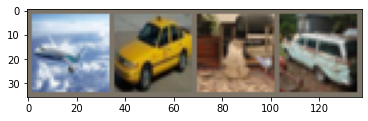

In [4]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
    correct = 0
    total = 0
    model.train(False)
    with torch.no_grad():
        for i,(images,labels)in enumerate(testloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(Variable(images))
            labels = Variable(labels)
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted.eq(labels)).sum().item()
        print('Test accuracy: %d %%' % (
            100 * correct / total))
    return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 152  # Train for 150 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs+1):
    model.train(True)
    epoch_loss  = 0
    i_count = 0
    acc_total = 0
    for i,(images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(Variable(images))
        loss = criterion(outputs,labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _,predicted = outputs.max(1)
        denom = labels.size(0)
        correct = predicted.eq(labels).sum().item()
        acc = 100*(correct/denom)
        acc_total += acc
        i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
    schedule.step()
    train_loss.append(epoch_loss)
    print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
    print('\n')
    test_acc = test()      # Print the test accuracy per epoch
    test_accuracy.append(test_acc)
  
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    path = './models/VGG16-BASE-nnmodule_50xdownsampled' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    torch.save(state,path)


In [5]:
test_accuracy

[10.0,
 10.0,
 10.0,
 10.01,
 11.24,
 9.98,
 9.84,
 9.91,
 10.040000000000001,
 10.12,
 10.059999999999999,
 10.18,
 10.17,
 10.299999999999999,
 10.290000000000001,
 10.280000000000001,
 10.16,
 10.01,
 9.8,
 9.78,
 10.23,
 10.56,
 10.82,
 10.75,
 10.96,
 10.68,
 11.03,
 11.020000000000001,
 11.08,
 11.110000000000001,
 11.09,
 10.97,
 11.14,
 11.28,
 11.26,
 11.21,
 11.219999999999999,
 11.62,
 12.21,
 12.030000000000001,
 11.39,
 12.16,
 12.19,
 11.940000000000001,
 11.799999999999999,
 12.2,
 12.31,
 12.280000000000001,
 12.35,
 12.540000000000001,
 12.590000000000002,
 12.31,
 12.4,
 12.47,
 12.53,
 12.5,
 12.65,
 12.559999999999999,
 12.559999999999999,
 12.78,
 12.93,
 13.19,
 13.420000000000002,
 13.4,
 13.200000000000001,
 13.350000000000001,
 13.41,
 13.350000000000001,
 13.16,
 13.43,
 13.54,
 13.55,
 13.420000000000002,
 13.569999999999999,
 13.530000000000001,
 13.4,
 13.600000000000001,
 14.099999999999998,
 13.87,
 14.12,
 14.08,
 13.99,
 13.91,
 14.069999999999999,
 14.

In [6]:
import pickle

with open("base_downsampled_accuracy.pkl", "wb") as output_file:
        pickle.dump(test_accuracy, output_file)